In [2]:
import os
import dlib, skvideo
import skvideo.io
import numpy as np
import cv2
import re
import warnings
import matplotlib.pyplot as plt
from matplotlib import patches
from pyVHR.signals.pyramid import *
from pyVHR.utils.SkinDetect import SkinDetect

class Video:
    """
    Basic class for extracting ROIs from video frames
    """

    facePadding = 0.2      # dlib param for padding
    filenameCompressed = "croppedFaces.npz"   # filename to store on disk
    saveCropFaces = False   # enable the storage on disk of the cropped faces
    loadCropFaces = False   # enable the loading of cropped faces from disk


    def __init__(self, filename, verb=0):
        self.filename = filename
        self.faces = np.array([])       # empty array of cropped faces (RGB)
        self.processedFaces = np.array([])
        self.faceSignal = np.array([])   # empty array of face signals (RGB) after roi/skin extraction

        self.verb = verb
        self.cropSize = [160,160]       # param for cropping
        self.typeROI = 'rect'           # type of rois between ['rect', 'skin']
        self.detector = 'dlib'

        self.doEVM =False
        self.EVMalpha = 20
        self.EVMlevels = 3
        self.EVMlow = .8
        self.EVMhigh = 4
        self.time_vid_start = 0
        self.rectCoords = [[0,0, self.cropSize[0], self.cropSize[1]]]  # default 'rect' roi coordinates
        self.skinThresh_fix = [40, 80]# default min values of Sauturation and Value (HSV) for 'skin' roi
        self.skinThresh_adapt = 0.2

    def getCroppedFaces(self, detector='mtcnn', extractor='skvideo'):
        """ Time is in seconds"""

        # -- check if cropped faces already exists on disk
        path, name = os.path.split(self.filename)
        filenamez = path + '/' + self.filenameCompressed
        self.detector = detector
        self.extractor = extractor
         # -- if compressed exists... load it
        self.cropped = False
            # -- metadata
        metadata = skvideo.io.ffprobe(self.filename)
        self.numFrames = int(eval(metadata["video"]["@nb_frames"]))
        self.height = int(eval(metadata["video"]["@height"]))
        self.width = int(eval(metadata["video"]["@width"]))
        self.frameRate = int(np.round(eval(metadata["video"]["@avg_frame_rate"])))
        self.duration = float(eval(metadata["video"]["@duration"]))
        self.codec = metadata["video"]["@codec_name"]
        # -- load video on a ndarray with skvideo or openCV
        video = None
        if extractor == 'opencv':
            video = self.__opencvRead()
        else:
            video = skvideo.io.vread(self.filename)
    # else if the video signal is stored as single frames
        
        print('\n\n' + detector + '\n\n')
        self.__extractFace(video, method=detector)
            # -- store cropped faces on disk
            

        if '1' in str(self.verb):
            self.printVideoInfo()
            if not self.cropped:
                print('      Extracted faces: not found! Detecting...')
            else:
                print('      Extracted faces: found! Loading...')
    def setMask(self, typeROI='rect',
                rectCoords=None, rectRegions=None,
                skinThresh_fix=None, skinThresh_adapt=None):
        self.typeROI = typeROI
        if self.typeROI == 'rect':
            self.rectCoords = self.__rectRegions2Coord(rectRegions = ['forehead', 'lcheek', 'rcheek', 'nose'])
        elif self.typeROI == 'skin_adapt' and skinThresh_adapt is not None:
            # Skin limits for HSV
            self.skinThresh_adapt = skinThresh_adapt
        elif self.typeROI == 'skin_fix' and skinThresh_fix is not None:
            # Skin limits for HSV
            self.skinThresh_fix = skinThresh_fix
    def printVideoInfo(self):
        print('\n   * Video filename: %s' %self.filename)
        print('         Total frames: %s' %self.numFrames)
        print('             Duration: %s (sec)' %np.round(self.duration,2))
        print('           Frame rate: %s (fps)' % self.frameRate)
        print('                Codec: %s' % self.codec)

        printOK = 1
        try:
            f = self.numFrames
        except AttributeError:
            printOK = 0

        if printOK:
            print('           Num frames: %s' % self.numFrames)
            print('               Height: %s' % self.height)
            print('                Width: %s' % self.height)
            print('             Detector: %s' % self.detector)
            print('            Extractor: %s' % self.extractor)          
    def __opencvRead(self):
        vid = cv2.VideoCapture(self.filename)
        frames = []
        retval, frame = vid.read()
        while retval == True:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            retval, frame = vid.read()
        vid.release()
        return np.asarray(frames)
    
    def extractSignal(self, frameSubset, count=None):
        if self.typeROI == 'rect':
            return self.__extractRectSignal(frameSubset)

        elif self.typeROI == 'skin_adapt' or self.typeROI == 'skin_fix':
            return self.__extractSkinSignal(frameSubset, count)
        
    def getMeanRGB(self):

        n_frames = len(self.faceSignal)
        n_roi = len(self.faceSignal[0])
        rgb = np.zeros([3, n_frames])

        for i in range(n_frames):
            mean_rgb = 0

            for roi in self.faceSignal[i]:
                idx = roi!=0
                idx2 = np.logical_and(np.logical_and(idx[:,:,0], idx[:,:,1]), idx[:,:,2])
                roi = roi[idx2]
                if len(roi)==0:
                    mean_rgb += 0
                else:
                    mean_rgb += np.mean(roi, axis=0)

            rgb[:,i] = mean_rgb/n_roi
        return rgb


    def __extractSkinSignal(self, frameSubset, count=None, frameByframe=False):
        """ Extract R,G,B values from skin-based roi of a frame subset """

        assert self.processedFaces.size > 0, "Faces are not processed yet! Please call runOffline first"

        self.faceSignal = []

        cp = self.cropSize
        skinFace = np.zeros([cp[0],cp[1],3], dtype='uint8')

        # -- loop on frames
        for i,r in enumerate(frameSubset):
            face = self.processedFaces[r]

            if self.typeROI == 'skin_fix':
                assert len(self.skinThresh_fix) == 2, "Please provide 2 values for Fixed Skin Detector"
                lower = np.array([5, self.skinThresh_fix[0], self.skinThresh_fix[1]], dtype = "uint8")
                upper = np.array([15, 255, 255], dtype = "uint8")
                converted = cv2.cvtColor(face, cv2.COLOR_RGB2HSV)
                skinMask = cv2.inRange(converted, lower, upper)
                skinFace = cv2.bitwise_and(face, face, mask=skinMask)
                self.faceSignal.append([skinFace])
            #if self.typeROI == 'skin_fix_ycbcr':
                #assert len(self.skinThresh_fix) == 2, "Please provide 2 values for Fixed Skin Detector"
                #minRange = np.array([0,133,77],dtype = "uint8")
                #maxRange = np.array([235,173,127],dtype = "uint8")
                #YCRimage = cv2.cvtColor(face,cv2.COLOR_BGR2YCR_CB)
                #apply min or max range on skin area in our image
                #skinArea = cv2.inRange(YCRimage,minRange,maxRange)
                #detectedSkin = cv2.bitwise_and(face, face, mask = skinArea)
                #self.faceSignal.append([skinFace])
            elif self.typeROI == 'skin_adapt':     
                sd = SkinDetect(strength=self.skinThresh_adapt)
                sd.compute_stats(face)
                skinFace = sd.get_skin(face, filt_kern_size=7, verbose=False, plot=False) 
                self.faceSignal.append([skinFace])

    def __extractFace(self, video, method, t_downsample_rate=2):

        # -- save on GPU
        if method == 'dlib':
            # -- dlib detector
            detector = dlib.get_frontal_face_detector()
            if os.path.exists("/Users/rupakkatwal/Downloads/pyVHR-master/pyVHR/resources/shape_predictor_68_face_landmarks.dat"):
                file_pred = "/Users/rupakkatwal/Downloads/pyVHR-master/pyVHR/resources/shape_predictor_68_face_landmarks.dat"
                predictor = dlib.shape_predictor(file_pred)
            self.faces = np.zeros([self.numFrames, self.cropSize[0], self.cropSize[1], 3],
                                  dtype='uint8')

            # -- loop on frames
            cp = self.cropSize
            self.faces = np.zeros([self.numFrames,cp[0],cp[1],3], dtype='uint8')
            for i in range(self.numFrames):
                frame = video[i,:,:,:]
                # -- Detect face using dlib
                self.numFaces = 0
                facesRect = detector(frame, 0)
                if len(facesRect) > 0:
                    # -- process only the first face
                    self.numFaces += 1
                    rect = facesRect[0]
                    x0 = rect.left()
                    y0 = rect.top()
                    w = rect.width()
                    h = rect.height()

                    # -- extract cropped faces
                    shape = predictor(frame, rect)
                    f = dlib.get_face_chip(frame, shape, size=self.cropSize[0], padding=self.facePadding)
                    self.faces[i,:,:,:] = f.astype('uint8')
                else:
                    print("No face detected at frame %s",i)
        elif method == 'mtcnn_kalman':
            #mtcnn detector
    
            from mtcnn import MTCNN
            detector = MTCNN()
            h0 = None
            w0 = None
            crop = np.zeros([2,2,2])
            skipped_frames = 0

            while crop.shape[:2] != (h0,w0):
                if skipped_frames > 0:
                    print("\nWARNING! Strange Face Crop... Skipping frame " + str(skipped_frames) + '...')
                frame = video[skipped_frames,:,:,:]
                detection = detector.detect_faces(frame)
                if len(detection) == 0:
                    skipped_frames += 1
                    continue
                if len(detection) > 1:
                    areas = []
                    for det in detection:
                        areas.append(det['box'][2] * det['box'][3])
                    areas = np.array(areas)
                    ia = np.argsort(areas)
                    [x0, y0, w0, h0] = detection[ia[-1]]['box']
                else:
                    try:
                        print(self.filename)
                        [x0, y0, w0, h0] = detection[0]['box']
                    except:
                        skipped_frames += 1
                        continue

                w0 = 2*(int(w0/2))
                h0 = 2*(int(h0/2))
                #Cropping face
                crop = frame[y0:y0+h0, x0:x0+w0, :]

                skipped_frames += 1

            self.cropSize = crop.shape[:2]

            if skipped_frames > 1:
                self.numFrames = self.numFrames - skipped_frames
                new_time_vid_start = skipped_frames / self.frameRate

                if new_time_vid_start > self.time_vid_start:
                    self.time_vid_start = new_time_vid_start
                    print("\tVideo now starts at " + str(self.time_vid_start) + " seconds\n")

            self.faces = np.zeros([self.numFrames, self.cropSize[0], self.cropSize[1], 3], dtype='uint8')
            self.faces[0,:,:,:] = crop

            #set the initial tracking window
            state = np.array([int(x0+w0/2),int(y0+h0/2),0,0], dtype='float64') # initial position

            #Setting up Kalman Filter
            kalman = cv2.KalmanFilter(4,2,0)
            kalman.transitionMatrix = np.array([[1., 0., .1, 0.],
                                                [0., 1., 0., .1],
                                                [0., 0., 1., 0.],
                                                [0., 0., 0., 1.]])
            kalman.measurementMatrix = 1. * np.eye(2, 4)
            kalman.processNoiseCov = 1e-5 * np.eye(4, 4)
            kalman.measurementNoiseCov = 1e-3 * np.eye(2, 2)
            kalman.errorCovPost = 1e-1 * np.eye(4, 4)
            kalman.statePost = state
            measurement = np.array([int(x0+w0/2), int(y0+h0/2)], dtype='float64')

            for i in range(skipped_frames,self.numFrames):
                frame = video[i,:,:,:]

                if i%t_downsample_rate == 0:
                    detection = detector.detect_faces(frame)
                    if len(detection) != 0:
                        areas = []
                        if len(detection) > 1:
                            for det in detection:
                                areas.append(det['box'][2] * det['box'][3])
                            areas = np.array(areas)
                            ia = np.argsort(areas)

                            [x0, y0, w, h] = detection[ia[-1]]['box']
                        else:
                            [x0, y0, w, h] = detection[0]['box']

                        not_found = False
                    else:
                        not_found = True

                prediction = kalman.predict() #prediction

                if i%t_downsample_rate == 0 and not not_found:
                    measurement = np.array([x0+w/2, y0+h/2], dtype='float64')
                    posterior = kalman.correct(measurement)
                    [cx0, cy0, wn, hn] = posterior.astype(int)
                else:
                    [cx0, cy0, wn, hn] = prediction.astype(int)

                #Cropping with new bounding box
                crop = frame[int(cy0-h0/2):int(cy0+h0/2), int(cx0-w0/2):int(cx0+w0/2), :]

                if crop.shape[:2] != self.faces.shape[1:3]:
                    print(self.filename)
                    print("WARNING! Strange face crop: video frame " + str(i) +" probably does not contain the whole face... Reshaping Crop\n")
                    try:
                        crop = cv2.resize(crop, (self.faces.shape[2], self.faces.shape[1]))
                    except:
                        continue

                self.faces[i,:,:,:] = crop.astype('uint8')

        else:

            raise ValueError('Unrecognized Face detection method. Please use "dlib" or "mtcnn"')
    def showVideo(self):
        from ipywidgets import interact
        import ipywidgets as widgets

        n = self.numFrames
        def view_image(frame):

            idx = frame-1

            if self.processedFaces.size == 0:
                face = self.faces[idx]
            else:
                face = self.processedFaces[idx]

            if self.typeROI == 'rect':
                plt.imshow(face, interpolation='nearest')

                ax = plt.gca()

                for coord in self.rectCoords:
                    rect = patches.Rectangle((coord[0],coord[1]),
                            coord[2],coord[3],linewidth=1,edgecolor='y',facecolor='none')
                    ax.add_patch(rect)

            elif self.typeROI == 'skin_fix':
                lower = np.array([0, self.skinThresh_fix[0], self.skinThresh_fix[1]], dtype = "uint8")
                upper = np.array([20, 255, 255], dtype = "uint8")
                converted = cv2.cvtColor(face, cv2.COLOR_RGB2HSV)
                skinMask = cv2.inRange(converted, lower, upper)
                skinFace = cv2.bitwise_and(face, face, mask=skinMask)
                plt.imshow(skinFace, interpolation='nearest')

            elif self.typeROI == 'skin_adapt':
                sd = SkinDetect(strength=self.skinThresh_adapt)
                sd.compute_stats(face)
                skinFace = sd.get_skin(face, filt_kern_size=7, verbose=False, plot=False)
                plt.imshow(skinFace, interpolation='nearest')

        interact(view_image, frame=widgets.IntSlider(min=1, max=n, step=1, value=1))
        
    def __sort_nicely(self, l):
        """ Sort the given list in the way that humans expect.
        """
        convert = lambda text: int(text) if text.isdigit() else text
        alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
        l.sort( key=alphanum_key )
        return l  
    

In [3]:
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal

def running_mean(x, N):
    cumsum_1 = np.cumsum(np.insert(x[0], 0, 0)) 
    cumsum_1 = (cumsum_1[N:] - cumsum_1[:-N]) / float(N)
    cumsum_2 = np.cumsum(np.insert(x[1], 0, 0)) 
    cumsum_2 = (cumsum_2[N:] - cumsum_2[:-N]) / float(N)
    cumsum_3 = np.cumsum(np.insert(x[2], 0, 0)) 
    cumsum_3 = (cumsum_3[N:] - cumsum_3[:-N]) / float(N)
    rgb = [cumsum_1,cumsum_2,cumsum_3]
    return rgb

def BP_filter(x, minHz, maxHz, fs, order=6):
    b, a = butter(order, Wn=[minHz, maxHz], fs=fs, btype='bandpass')
    y = lfilter(b, a, x)
    return y

def zeroMeanSTDnorm(x):
    # -- normalization along rows (1-3 channels)
    mx = x.mean(axis=1).reshape(-1,1)
    sx = x.std(axis=1).reshape(-1,1)
    y = (x - mx) / sx
    return y

In [4]:
import numpy as np
from plotly.subplots import make_subplots
from scipy.signal import find_peaks, stft, lfilter, butter, welch
from plotly.colors import n_colors
import plotly.graph_objects as go
from scipy.interpolate import interp1d
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

class BVPsignal:
    """
        Manage (multi-channel, row-wise) BVP signals
    """
     # freq. resolution for STFTs
    step = 1       # step in seconds
    nFFT = 2048

    def __init__(self, data, fs, startTime=0, minHz=0.6, maxHz=4.0, verb=False):
        if len(data.shape) == 1:
            self.data = data.reshape(1,-1) # 2D array raw-wise
        else:
            self.data = data
        self.numChls = self.data.shape[0]  # num  channels
        self.fs = fs                       # sample rate
        self.startTime = startTime
        self.verb = verb
        self.minHz = minHz
        self.maxHz = maxHz

        
    def getBPM(self, winsize=5):
        self.spectrogram(winsize, use_hps=False)
        return self.bpm, self.times
    
    
    def PSD2BPM(self, chooseBest=True, use_hps=False):
        """
            Compute power spectral density using Welch’s method and estimate
            BPMs from video frames
        """

        # -- interpolation for less than 256 samples
        c,n = self.data.shape
        if n < 256:
            seglength = n
            overlap = int(0.8*n)  # fixed overlapping
        else:
            seglength = 256
            overlap = 128
       
        # -- periodogram by Welch
        F, P = welch(self.data, nperseg=seglength, noverlap=overlap,fs=self.fs,window ='hamming', nfft=self.nFFT,scaling ='density')
        # -- freq subband (0.7 Hz - 4.0 Hz)
        print(F)
        self.band = np.argwhere((F > self.minHz) & (F < self.maxHz)).flatten()
        self.band_LF = np.argwhere((F > 0.04) & (F < 0.15)).flatten()
        self.band_HF = np.argwhere((F > 0.15) & (F < 0.4)).flatten()
        self.Power = P[:,self.band]
        self.Power_LF = P[:,self.band_LF]
        self.Power_HF = P[:,self.band_HF]
        # -- BPM estimate by PSD)
        self.Pmax = np.max(self.Power, axis=1)
        self.Psum = np.sum(self.Power,axis = 1)
        self.Pratio = self.Pmax/self.Psum
        self.Pmax = np.max(self.Power, axis=1)
        self.RR = np.max(self.Power_HF, axis=1)
        self.Pmax_LF = np.max(self.Power_LF, axis=1)
        self.Psum_LF = np.sum(self.Power_LF,axis = 1)
        self.Pratio_LF = self.Pmax_LF/self.Psum_LF
        self.AUC_LF= auc(self.band_LF,self.Power_LF[0])
        self.Pmax_HF = np.max(self.Power_HF, axis=1)
        self.Psum_HF = np.sum(self.Power_HF,axis = 1)
        self.Pratio_HF = self.Pmax_HF/self.Psum_HF
        self.AUC_HF= auc(self.band_HF,self.Power_HF[0])
        self.LF_HF= self.AUC_LF/self.AUC_HF
        self.AUC_Method=auc(self.band,self.Power[0])

    

    def findPeaks(self, distance=None, height=None):
        
        # -- take the first channel
        x = self.data[0].flatten()
            
        if distance is None:
            distance = self.fs/2
        if height is None:
            height = np.mean(x)

        # -- find peaks with the specified params
        self.peaks, _ = find_peaks(x, distance=distance, height=height)
        
        self.peaksTimes = self.peaks/self.fs
        self.bpmPEAKS = 60.0/np.diff(self.peaksTimes)
        
    def plotBPMPeaks(self, height=None, width=None):
        """
            Plot the the BVP signal and peak marks
        """

        # -- find peaks  
        try:
            peaks = self.peaks
        except AttributeError:
            self.findPeaks()
            peaks = self.peaks
        
        #-- signals 
        y = self.data[0]
        n = y.shape[0]
        startTime  = self.startTime 
        stopTime = startTime+n/self.fs
        x = np.linspace(startTime, stopTime, num=n, endpoint=False)
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, name="BVP"))
        fig.add_trace(go.Scatter(x=x[peaks], y=y[peaks], mode='markers', name="Peaks"))

        if not height:
            height=400
        if not width:
            width=800

        fig.update_layout(height=height, width=width, title="BVP signal + peaks",
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"))
        
        fig.show()
        
    def plot(self, title="BVP signal", height=400, width=800):
        """
            Plot the the BVP signal (multiple channels)
        """
      
        #-- signals 
        y = self.data
        c,n = y.shape
        startTime  = self.startTime 
        stopTime = startTime+n/self.fs
        x = np.linspace(startTime, stopTime, num=n, endpoint=False)
        
        fig = go.Figure()
        
        for i in range(c):
            name = "BVP " + str(i)
            fig.add_trace(go.Scatter(x=x, y=y[i], name=name))

        fig.update_layout(height=height, width=width, title=title,
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"))
        fig.show()
        
    def displayPSD(self, ch):
        """Show the periodogram(s) of the BVP signal for channel ch"""
        if ch == 'HF':
            print("I am lf_psd")
            f_LF = self.band_LF
            P_LF = self.Power_LF [0]

            plt.plot(f_LF, P_LF, marker='.', label='PSD')
            # axis labels
            plt.xlabel('Frequency')
            plt.ylabel('Power')
            # show the legend
            plt.legend()
            # show the plot
            plt.show()

        if ch == 'HF':
            print("I am hf_psd")
            f_HF = self.band_HF
            P_HF = self.Power_HF[0]

            plt.plot(f_HF, P_HF, marker='.', label='PSD')
            # axis labels
            plt.xlabel('Frequency')
            plt.ylabel('Power')
            # show the legend
            plt.legend()
            # show the plot
            plt.show()
        if ch == 'BPV':
            f = self.band
            P = self.Power[0]
            plt.plot(f, P, marker='.', label='PSD')
            # axis labels
            plt.xlabel('Frequency')
            plt.ylabel('Power')
            # show the legend
            plt.legend()
            # show the plot
            plt.show()
  
  

In [7]:
import configparser
import ast
import pandas as pd
import glob, os
from importlib import import_module
import numpy as np
from scipy.signal import medfilt, detrend
import plotly.graph_objects as go
from pyVHR.utils import filters, printutils,detrending

class TestSuite():
    
    def __init__(self, configFilename='default'):
        if configFilename == 'default':
            configFilename = '/Users/rupakkatwal/Downloads/pyVHR-master/pyVHR/analysis/default_test.cfg'
        self.parse_cfg(configFilename)
    
    def start(self, saveResults=True, outFilename=None, verb=0):
        """ Runs the tests as specified in the loaded config file.
            verbose degree:
               0 - not verbose
               1 - show the main steps
               2 - display graphic 
               3 - display spectra  
               4 - display errors
               (use also combinations, e.g. verb=21, verb=321)
        """     
            
        # -- catch data (object)
        res = TestResult()
        res.newDataSerie()

        # -- video object
        os.chdir(self.videodict['videodataDIR'])
        for file in glob.glob("*.avi"):
            videoFilename = os.path.join(self.videodict['videodataDIR'], file)
            video = Video(videoFilename, verb)
            video.getCroppedFaces(detector=self.videodict['detector'],
                                  extractor=self.videodict['extractor'])
            # -- catch data
            
            etime = float(self.videodict['endTime'])
            if etime < 0:
                self.videodict['endTime'] = str(video.duration-etime)
            startTime = float(self.videodict['startTime'])
            timeStep  = float(self.defaultdict['timeStep'])
            winSize = float(self.defaultdict['winSize'])
            zeroMeanSTDnorm = int(self.defaultdict['zeroMeanSTDnorm'])
            detrFilter = int(self.defaultdict['detrending'])
            if 'detrending' in self.defaultdict:
                detrending = int(self.defaultdict['detrending'])
            else:
                detrLambda = 10
            if 'detrMethod' in self.videodict:
                detrMethod = self.videodict['detrMethod']
            else:
                detrMethod = 'tarvainen'
            if self.videodict['endTime']=='INF':
                endTime = np.Inf
            else:
                endTime= float(self.videodict['endTime'])
            if 'BPfilter' in self.defaultdict:
                BPfilter = int(self.defaultdict['BPfilter'])
            else:
                BPfilter = 1
            if 'minHz' in self.defaultdict:
                minHz = float(self.defaultdict['minHz'])
            else:
                minHz = 0.6
            if 'maxHz' in self.defaultdict:
                maxHz = float(self.defaultdict['maxHz'])
            else:
                maxHz = 4.0
            fs = video.frameRate
            if endTime > video.duration:
                endTime = video.duration
            assert startTime <= endTime, "Time interval error!"
            assert timeStep > 0, "Time step must be positive!"
            assert winSize  < (endTime - startTime),"Winsize too big!"

            if video.doEVM is True:
                video.applyEVM()
            else:
                video.processedFaces = video.faces
            timeSteps = np.arange(startTime,endTime,timeStep)
            startFrame = int(video.frameRate)
            endFrame = int(video.numFrames)
            frameSubset = np.arange(startFrame, endFrame)
            ROImask = self.videodict['ROImask']
            if ROImask == 'rect':
                rects = ast.literal_eval(self.videodict['rectCoords'])
                self.rectCoords = []
                for x in rects:
                    rect = []
                    for y in x:
                        rect.append(int(y))
                    self.rectCoords.append(rect)
                video.setMask(ROImask, rectCoords=self.rectCoords)
            elif ROImask == 'skin_adapt':
                video.setMask(ROImask, skinThresh_adapt=float(self.videodict['skinAdapt']))
            elif ROImask == 'skin_fix':
                threshs = ast.literal_eval(self.videodict['skinFix'])
                threshSkinFix = [int(x) for x in threshs]
                video.setMask(ROImask, skinThresh_fix=threshSkinFix)
            else:
                raise ValueError(ROImask + " : Unimplemented Signal Extractor!")
            video.extractSignal(frameSubset)
            video.showVideo()
            RGBsig = video.getMeanRGB()
            # -- print RGB raw data
            if '2' in str(verb):
                printutils.multiplot(y=RGBsig, name=['ch B', 'ch R','ch G'], title='RGB raw data')
            RGBsig = running_mean(RGBsig,3)
            if detrending:
                RGBsig = detrend(RGBsig)
            RGBsig = running_mean(RGBsig,3)
            RGBsig = BP_filter(RGBsig, minHz, maxHz, fs)
            print(RGBsig)
            Numerator = np.std(abs(RGBsig[0]))/np.mean(abs(RGBsig[0]))
            Denomenator = np.std(abs(RGBsig[1]))/np.mean(abs(RGBsig[1]))
            R = (Numerator/Denomenator)
            SPO2 = 115.31 -(R * 20.85)
            RedCh = BVPsignal(RGBsig[0], video.frameRate, startTime, minHz, maxHz, verb)
            RedCh.PSD2BPM(chooseBest=True )
            BlueCh = BVPsignal(RGBsig[1], video.frameRate, startTime, minHz, maxHz, verb)
            BlueCh.PSD2BPM(chooseBest= True)
            GreenCh = BVPsignal(RGBsig[2], video.frameRate, startTime, minHz, maxHz, verb)
            GreenCh.PSD2BPM(chooseBest=True)
            for methodName in  self.methods:
                res.newDataSerie()
                moduleName = methodName.lower()
                className = methodName.upper()
                self.methodsdict[methodName]['video'] = video
                self.methodsdict[methodName]['verb'] = verb
                # merge video parameters dict in method parameters dict before calling method
                self.__merge(self.methodsdict[methodName], self.videodict)
                methodModule = import_module('.methods.' + moduleName, package='pyVHR')
                classOBJ = getattr(methodModule, className)
                obj = classOBJ(**self.methodsdict[methodName])
                rPPG_BVP_signal = obj.apply(RGBsig)
                print(rPPG_BVP_signal)
                systolic_peak = max(np.diff(rPPG_BVP_signal,2))
                diastolic_peak = min(np.diff(rPPG_BVP_signal,2))
                BVP_max  = np.max(rPPG_BVP_signal)
                BVP_ratio = np.max(rPPG_BVP_signal) / np.sum(rPPG_BVP_signal)
                BVP_STD = np.std(rPPG_BVP_signal)
                BVP_mean = np.mean(rPPG_BVP_signal)
                rPPG_BVP = BVPsignal(rPPG_BVP_signal, video.frameRate, startTime, minHz, maxHz, verb)
                rPPG_BVP.plotBPMPeaks()
                rPPG_BVP.PSD2BPM(chooseBest = True)
                rPPG_BVP.displayPSD(ch = "BPV")
                rPPG_BVP.displayPSD(ch = "LF")
                rPPG_BVP.displayPSD(ch = "HF")
                if videoFilename.endswith('.avi'):
                    videoFilename = videoFilename[:-4]
                res.addData('videoFilename', videoFilename)
                res.addData('Red_P', RedCh.Pmax[0])
                res.addData('Red_R', RedCh.Pratio[0])
                res.addData('Blue_P', BlueCh.Pmax[0])
                res.addData('Blue_R', BlueCh.Pratio[0])
                res.addData('Green_P', GreenCh.Pmax[0])
                res.addData('Green_R', GreenCh.Pratio[0])
                res.addData('SPO2', SPO2)
                res.addData('BVP_ratio',BVP_ratio)
                res.addData('BVP_max', BVP_max)
                res.addData('BVP_mean', BVP_mean)
                res.addData('BVP_STD', BVP_STD)
                res.addData('Method', methodName)
                res.addData('LF_P', rPPG_BVP.Pmax_LF[0])
                res.addData('LF_R', rPPG_BVP.Pratio_LF[0])
                res.addData('AUC_LF', rPPG_BVP.AUC_LF)
                res.addData('HF_P', rPPG_BVP.Pmax_HF[0])
                res.addData('HF_R', rPPG_BVP.Pratio_HF[0])
                res.addData('AUC_HF', rPPG_BVP.AUC_HF)
                res.addData('LF_HF', rPPG_BVP.LF_HF)
                res.addData('Method_P', rPPG_BVP.Pmax[0])
                res.addData('Method_R', rPPG_BVP.Pratio[0])
                res.addData('Method_AUC', rPPG_BVP.AUC_Method)
                res.addDataSerie()
        if saveResults:
            res.saveResults()

        return res
    
    def parse_cfg(self, configFilename):
        """ parses the given config file for experiments. """
        self.parser = configparser.ConfigParser(inline_comment_prefixes=('#', ';'))
        self.parser.optionxform = str
        if not self.parser.read(configFilename):
            raise FileNotFoundError(configFilename)
            
        # checks 
        assert not self.parser.has_section('DEFAULT'),"ERROR... DEFAULT section is mandatory!"
            
        # load default paramas
        self.defaultdict = dict(self.parser['DEFAULT'].items())
        # load video params
        self.videodict = dict(self.parser['VIDEO'].items())
        # video idx list extraction
        if self.videodict['videoIdx'] == 'all':
            self.videoIdx = 'all'
        else:
            svid = ast.literal_eval(self.videodict['videoIdx'])
            self.videoIdx = [int(v) for v in svid]
        self.methodsdict = {}
        self.methods = ast.literal_eval(self.defaultdict['methods'])
        for x in self.methods:
            self.methodsdict[x] = dict(self.parser[x].items())
        
    def __merge(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key]= dict2[key]

class TestResult():
    """ Manage the results of a test for a given video dataset and multiple VHR methods"""
    
    def __init__(self, filename=None):

        if filename == None:
            self.dataFrame = pd.DataFrame()
        else:
            self.dataFrame = pd.read_hdf(filename)
        self.dict = None
        
    def addDataSerie(self):
        # -- store serie
        if self.dict != None:
            self.dataFrame = self.dataFrame.append(self.dict, ignore_index=True)
            
    def newDataSerie(self):
        # -- new dict
        D = {}      # video filename
        D['videoFilename'] = ''
        D['systolic_peak'] = ''
        D['diastolic_peak'] = ''
        D['Red_P'] = ''
        D['Red_R'] = ''
        D['Blue_P'] = ''
        D['Blue_R'] = ''
        D['Green_P'] = ''
        D['Green_R'] = ''
        D['SPO2'] = ''
        D['BVP_ratio'] = ''
        D['BVP_max'] = ''
        D['BVP_mean'] = ''
        D['BVP_STD'] = ''
        D['Method'] = ''
        D['Sum_LF'] = ''
        D['AUC_LF'] = ''
        D['Sum_HF'] = ''
        D['AUC_HF'] = ''
        D['LF_HF'] = ''
        D['Method_P'] = ''
        D['Method_R'] = ''
        D['Method_AUC'] = ''
        self.dict = D

    def addData(self, key, value):
        self.dict[key] = value
                         
    def saveResults(self, outFilename=None):
        if outFilename == None:
            outFilename = "testResults.h5"
        else:
            self.outFilename = outFilename
        
        # -- save data
        self.dataFrame.to_hdf(outFilename, key='df', mode='w')
        self.dataFrame.to_hdf(outFilename, key='df', mode='w')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           



mtcnn_kalman


/Users/rupakkatwal/Downloads/rppgdataset/test/01_01_01_C.avi

   * Video filename: /Users/rupakkatwal/Downloads/rppgdataset/test/01_01_01_C.avi
         Total frames: 300
             Duration: 10.0 (sec)
           Frame rate: 30 (fps)
                Codec: mpeg4
           Num frames: 300
               Height: 480
                Width: 480
             Detector: mtcnn_kalman
            Extractor: sklearn
      Extracted faces: not found! Detecting...


interactive(children=(IntSlider(value=1, description='frame', max=300, min=1), Output()), _dom_classes=('widge…

[[ 2.58101661e-04  2.79413570e-03  1.43079106e-02  4.60097951e-02
   1.03206112e-01  1.66862426e-01  1.85520434e-01  9.72479238e-02
  -1.22988620e-01 -4.24954617e-01 -6.90404877e-01 -7.89916968e-01
  -6.54755677e-01 -3.17881497e-01  1.00778054e-01  4.55612524e-01
   6.48365871e-01  6.72609571e-01  6.05766166e-01  5.54929766e-01
   5.89237569e-01  6.98078331e-01  7.98119010e-01  7.83977639e-01
   5.92269579e-01  2.39759245e-01 -1.88104327e-01 -5.87872462e-01
  -8.90169075e-01 -1.07903294e+00 -1.17465635e+00 -1.20218133e+00
  -1.17076974e+00 -1.07122960e+00 -8.86678311e-01 -6.07555656e-01
  -2.45147317e-01  1.60082294e-01  5.39852348e-01  8.14438687e-01
   9.24192100e-01  8.63504926e-01  6.93812898e-01  5.18310426e-01
   4.26121479e-01  4.39779687e-01  5.03388231e-01  5.22582511e-01
   4.29070282e-01  2.22858642e-01 -3.64934341e-02 -2.75470281e-01
  -4.46932084e-01 -5.36770519e-01 -5.46479756e-01 -4.80655056e-01
  -3.51881318e-01 -1.89090120e-01 -3.18555636e-02  8.81127917e-02
   1.61777

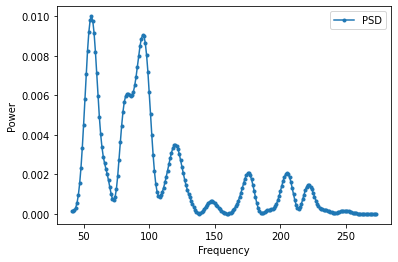

I am lf_psd


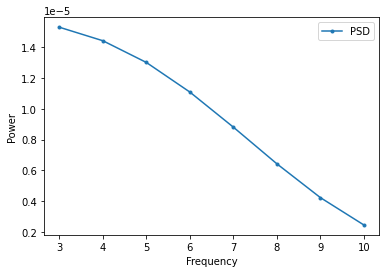

I am hf_psd


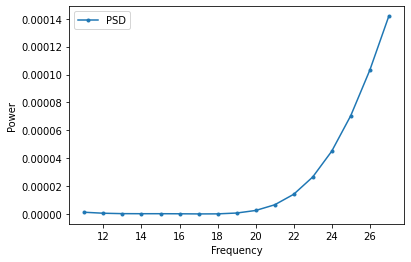

In [8]:
cfgFilename = '/Users/rupakkatwal/Downloads/pyVHR-master/pyVHR/analysis/sample.cfg'
test = TestSuite(configFilename=cfgFilename) 
result1= test.start(outFilename='sampleExp.h5',verb = 1)

In [ ]:
result1.dataFrame

In [ ]:
a = result1.dataFrame.shape
for i in range(a[0]):
    systolic_peak = result1.dataFrame.loc[i,"systolic_peak"]
    diastolic_peak = result1.dataFrame.loc[i,"diastolic_peak"]
    Red_P = result1.dataFrame.loc[i,"Red_P"]
    Red_R = result1.dataFrame.loc[i,"Red_R"]
    Green_P = result1.dataFrame.loc[i,"Green_P"]
    Green_R = result1.dataFrame.loc[i,"Green_R"]
    Blue_P = result1.dataFrame.loc[i,"Blue_P"]
    Blue_R = result1.dataFrame.loc[i,"Blue_R"]
    SPO2 = result1.dataFrame.loc[i,"SPO2"]
    BVP_ratio = result1.dataFrame.loc[i,"BVP_ratio"]
    BVP_max = result1.dataFrame.loc[i,"BVP_max"]
    BVP_mean = result1.dataFrame.loc[i,"BVP_mean"]
    BVP_STD = result1.dataFrame.loc[i,"BVP_STD"]
    LF_P = result1.dataFrame.loc[i,"LF_P"]
    LF_R = result1.dataFrame.loc[i,"LF_R"]
    AUC_LF = result1.dataFrame.loc[i,"AUC_LF"]
    HF_P = result1.dataFrame.loc[i,"HF_P"]
    HF_R = result1.dataFrame.loc[i,"HF_R"]
    AUC_HF = result1.dataFrame.loc[i,"AUC_HF"]
    LF_HF = result1.dataFrame.loc[i,"LF_HF"]
    Method_P = result1.dataFrame.loc[i,"Method_P"]
    Method_R = result1.dataFrame.loc[i,"Method_R"]
    Method_AUC = result1.dataFrame.loc[i,"Method_AUC"]
    csvName = result1.dataFrame.loc[i,"videoFilename"]
    print(csvName + ".csv")
    df = pd.DataFrame({"systolic_peak" : [systolic_peak],"diastolic_peak" : [diastolic_peak], "Red_P" : [Red_P],"Red_R" : [Red_R],"Green_P" : [Green_P], "Green_R" : [Green_R], "Blue_P" : [Blue_P], "Blue_R" : [Blue_R],"SPO2": [SPO2],"BVP_ratio": [BVP_ratio],"BVP_max": [BVP_max],"BVP_mean": [BVP_mean],"BVP_STD": [BVP_STD],"LF_P": [LF_P],"LF_R": [LF_R],"AUC_LF": [AUC_LF],"HF_P": [HF_P],"HF_R": [HF_R],"AUC_HF": [AUC_HF],"LF_HF": [LF_HF],"Method_P": [Method_P],"Method_R": [Method_R],"Method_AUC": [Method_AUC]},columns=['systolic_peak','diastolic_peak', 'Red_P','Red_R','Green_P', 'Green_R','Blue_P','Blue_R','SPO2', 'BVP_ratio', 'BVP_max','BVP_mean','BVP_STD','LF_P','LF_R','AUC_LF','HF_P','HF_R','AUC_HF','LF_HF','Method_P','Method_R','Method_AUC'])
    df.to_csv(csvName + ".csv", index = False)

In [82]:
df.style

,systolic_peak,diastolic_peak,Red_P,Red_R,Green_P,Green_R,Blue_P,Blue_R,SPO2,BVP_ratio,BVP_max,BVP_mean,BVP_STD,LF_P,LF_R,AUC_LF,HF_P,HF_R,AUC_HF,LF_HF,Method_P,Method_R,Method_AUC
0,,,0.416518,0.037212,0.570240,0.040211,0.791218,0.037621,96.427647,0.242478,0.127470,0.004493,0.066775,0.000098,0.142352,0.000603,0.000063,0.165367,0.000350,1.724414,0.010298,0.029765,0.345770
